In [2]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

import numpy as np
from matplotlib import pyplot as plt
from util import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Constraints via Projection and Decomposition

## A Nasty Example

**We used Lagrangian approaches to tackle constrained training problems:**

$$
\text{argmin}_{\omega} \left\{ L(y) \mid g(y) \leq 0 \right\} \text{ with: } y = f(\hat{x}, \omega)
$$

They work well, but:

* They require differentiability of $g$ to use gradient descent
* ...And taking advantage of mini-batches is tricky

**Let's consider a particularly bad case**

Say we want to have _perfectly balanced output_ in a binary classifier:
$$
\sum_{i = 1}^{m} {\rm round}(y_{i}) = \frac{m}{2}
$$
* Where $y_{i}$ is the positive-class output for example $i$

## A Nasty Example

**First, the constraint is not differentiable**

We can obtain a differentiable approximation by removing rounding:
$$
\sum_{i = 1}^{m} y_{i} = \frac{m}{2}
$$
* But now we can satisfy the constraint by having $y_{i} = 0.5$ for all examples!

**Second, the constraint is defined on the whole training set**

We can restrict our focus to the example $I_k$ in mini-batch $k$:
$$
\sum_{i \in I_k}^{m} {\rm round}(y_{i}) = \frac{|I_k|}{2}
$$
* But now we'll have at best _stochastic_ constraint satisfaction!

## A Nasty Example

**We could thinks of using the Projected Gradient Method**

Let's consider our example from this point of view:

$$
\sum_{i = 1}^{m} {\rm round}(y_{i}) = \frac{m}{2}, \text{ with: } y = f(\hat{x}, \omega)
$$


* The constraint on $y$ is simple
  - ...But not so it's translation on $\omega$
* The constraint is relational
  - Hence, using mini-batches leads to stochastic noise
  - ...And not using them may cause scalability issues
* The constraint is non-differentiable, non-convex, and non-separable
  - Hence, projecting can be an expensive operation

## Moving Targets

**One way around these issues is provided by the [Moving Targets](https://www.aaai.org/AAAI21Papers/AAAI-9549.DetassisF.pdf) method**

...Which is designed for constrained _supervised_ learning, i.e.:

$$
\text{argmin}_{\omega} \left\{ L(y, \hat{y}) \mid y \in C \right\} \text{ with: } y = f(\hat{x}, \omega)
$$

* Where $\hat{y}$ is the target (or label) vector and $L(y, \hat{y})$ is the loss function

**MT makes projection scalable by working _in output space_**

The method alternates between _learner_ and _master_ steps

* At evey step $k$, we maintain a prediction $y^k$ and an _adjusted target $z^k$_
* In master steps, we _move $z^k$_ so as to make it feasible and closer to $\hat{y}$
* In learner steps, we train an ML model to make $y^k$ close to $z^k$

**Here we will present a _revised version_ of the original algorithm**

## Moving Targets

**The _master step_ can be derived from a Taylor expansion**

By assuming that $L(y, \hat{y})$ is differentiable (as in the PGM) we can write:

$$
L(y, \hat{y}) \simeq L(y^k, \hat{y}) + \nabla_{y} L(y^k, \hat{y}) (z - y^k) + o(\|z - y^k\|_2^2)
$$

Then we look for an adjusted target vector $z$ that is:

* Feasible w.r.t. to $C$, improving in terms of loss w.r.t. $\hat{y}$
* ...And close enough to $y^k$ (for the linear approximation to be reliable)

**In practice, this is done by solving:**

$$
\text{argmin}_{z} \left\{ \alpha \nabla_y L(y^k, \hat{y}) (z - y^k) + \|z - y^k\|_2^2 \mid z \in C \right\}
$$

* Which is obtained from the Taylor expansion by adding an $\alpha$ parameter

## Moving Targets

**Let's look closer at the master step problem**

$$
\text{argmin}_{z} \left\{ \alpha \nabla_y L(y, \hat{y}) (z - y^k) + \|z - y^k\|_2^2 \mid z \in C \right\}
$$

* By changing $\alpha$, we can control how close we are to $y^k$
  - For $\alpha = 0$, we actually obtain a projection operator
* We can use _any solution technique_ (including MILP, CP, SMT...)
  - Meaning that we can _apply_ the method for basically any kind of constraint
  - ...Though convergence may be trickier in some cases
* The ML model $f(x, \omega)$ is missing in the formulation
  - We are working _with the target vector alone_ (i.e. in output space)
  - ...Which makes it much easier to deal with large-scale relational constraints

## Moving Targets

**The master step**

$$
\text{argmin}_{z} \left\{ \alpha \nabla_y L(y^k, \hat{y}) (z - y^k) + \|z - y^k\|_2^2 \mid z \in C \right\}
$$

* ...Can be thought of as merging gradient descent & projection from the PGM
* I.e. it's almost equivalent to performing:

$$
z^{(k)} = {\bf proj}_{C} \left(y^{(k)} - \eta^{(k)} \nabla_{z} L(y^{(k)}, \hat{y}) \right)
$$

**As a main difference, everything is done in output space**

* I.e. we change $z^k$, rather than changing $\omega$

> **But how do we actually update the ML model?**

## Moving Targets

**Changing the ML model is purpose of the _learner step_**

Given a target vector $z^k$, this consists in solving:

$$
\text{argmin}_{\omega} L(y, z^k) \text{ with: } y = f(\hat{x}, \omega)
$$

...Which is a _traditional supervised learning_ problem

**The step can _also_ be viewed as a for of projection:**

$$
\text{argmin}_{y} \left\{ L(y, z^k) \mid y \in B \right\} \text{ with: } B = \{y \mid \exists \omega, y = f(\hat{x}, \omega) \}
$$

Where $B$ (model bias) is the set of output that can be reached by the model

* This perspective is useful to understand the algorithm behavior
* ...But of course it does not alter the way we train

## Moving Targets

**The overall method is as follows:**

* $y^{0} = \text{argmin}_{y} \left\{ L(y, \hat{y}) \mid y \in B \right\}$
* For $k = 1..n$:
  - $z^{k} = \text{argmin}_{z} \left\{ \alpha \frac{1}{k} \nabla_y L(y^k, \hat{y}) (z - y^k) + \|z - y^k\|_2^2, \text{ s.t. } z \in C \right\}$
  - $y^{k+1} = \text{argmin}_{y} \left\{ L(y, z^k) \mid y \in B \right\}$

**Some highlights**

* You can use any technique for either step (it's a full decomposition)
* Non differentiable constraints can be handled via CP, SMT, MP, meta-heuristics
* Batching is not needed in the master step (when constraints are handled)
* $\alpha$ is divided by $k$ at each iteration to ensure convergence

## Moving Targets

**The overall method is as follows:**

* $y^{0} = \text{argmin}_{y} \left\{ L(y, \hat{y}) \mid y \in B \right\}$
* For $k = 1..n$:
  - $z^{k} = \text{argmin}_{z} \left\{ \alpha \frac{1}{k} \nabla_y L(y^k, \hat{y}) (z - y^k) + \|z - y^k\|_2^2, \text{ s.t. } z \in C \right\}$
  - $y^{k+1} = \text{argmin}_{y} \left\{ L(y, z^k) \mid y \in B \right\}$

**Speaking of convergence**

* At the momento of writing, a formal proof is still missing
* ...But the method is _still applicable_ as a heuristic

# A Running Example

## A Toy Learning Problem

**Say we want to fit a model in the form:**
$$
\tilde{f}(x, \beta) = x^\beta
$$
...Based on _just two observations_

**For evaluation purpose, we assume we know the true curve, i.e.:**
$$
f(x) = x^{0.579} 
$$
And hence we can obtain the true $y$ values:

In [3]:
xm = np.array([1.5, 3])
ym = np.array([1.2, 2.2])

f_true = lambda x: x**0.579
yt = f_true(xm)

## A Toy Learning Problem

**We can now plot both the true curve and the measured $x, y$ points:**

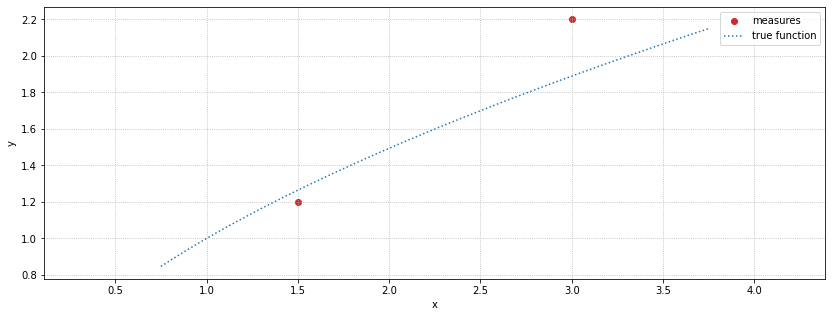

In [4]:
util.mtx_function_plot(xm, ym, f_true, figsize=figsize)

* We are underestimating the first point and overestimatng the second
* ...Which may easily trick our simple model

## Learner Step

**We can now perform the first learner step**

For this example, we can use any curve fitting method

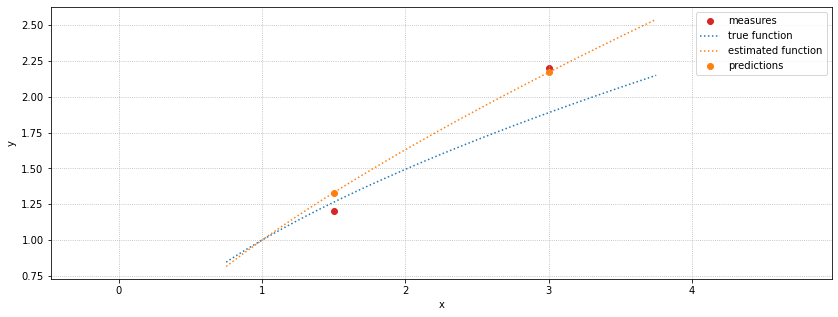

In [5]:
f_pred = util.mtx_learner_step(xm, ym)
util.mtx_function_plot(xm, ym, f_true, f_pred, figsize=figsize)

* The learner model indeed overestimates the curve slope
* More data could fix the issue, but we will rely instead on _constraints_

## Taking Advantage of Constraints

**Before that, let's view measurements and predictions in output space**

...Where they both look like _points_

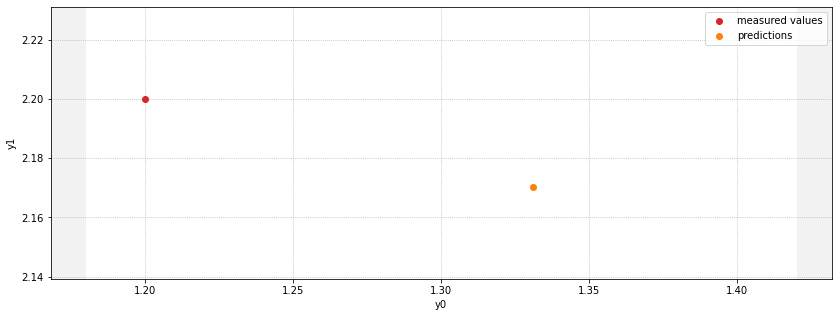

In [6]:
yp = f_pred(xm)
util.mtx_output_plot(xm, ym, yp, figsize=figsize)

## Visualizing Model Bias

**By changing the $\beta$ in our model we can change the prediction vector**

We can draw a range of potential predictions in output space (part of $B$)

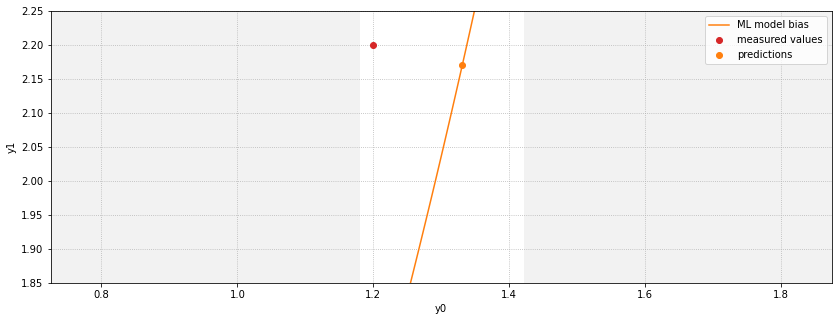

In [7]:
yp = f_pred(xm)
util.mtx_output_plot(xm, ym, yp, plot_bias=True, figsize=figsize, ylim=(1.85, 2.25))

* This represents the bias $B$ of our ML model

## Taking Advantage of Constraints

**Say we know that our two measurements must obey**
$$
y_1 \leq \frac{3}{2} y_0
$$

We can draw the feasible set $C$ in output space, too!

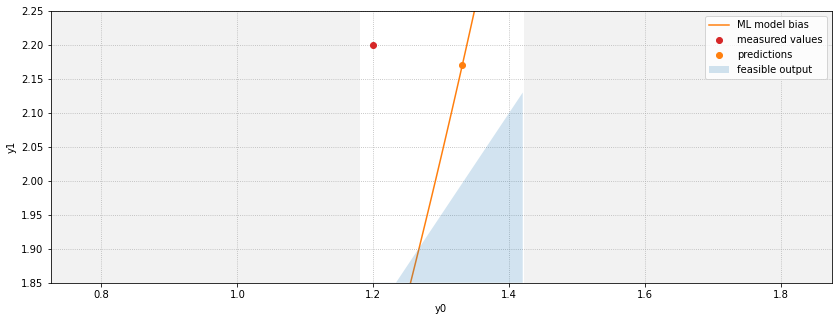

In [8]:
f_bound = lambda y0: 1.5*y0
util.mtx_output_plot(xm, ym, yp, plot_bias=True, f_bound=f_bound, figsize=figsize, ylim=(1.85, 2.25))

## Master Step

**We can now perform the first master step**

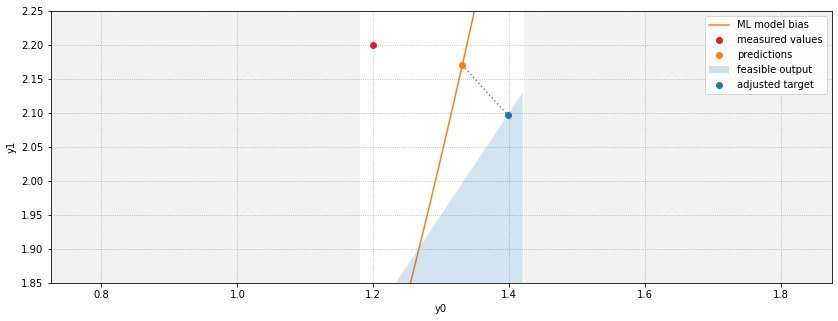

In [9]:
yf = util.mtx_master_step_alpha(ym, yp, alpha=0.5)
util.mtx_output_plot(xm, ym, yp, plot_bias=True, f_bound=f_bound, yf=yf, figsize=figsize, ylim=(1.85, 2.25))

* The result is similar to a projection
* ...Except that it is a bit closer to the true target

## Second Learner Step

**We can now perform and visualize a second learner step**

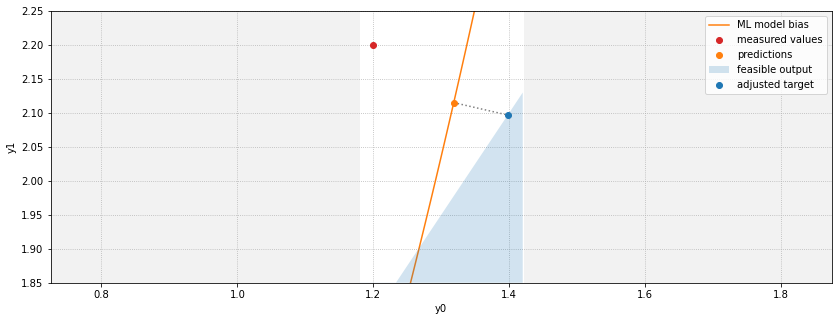

In [10]:
f_pred2 = util.mtx_learner_step(xm, yf)
yp2 = f_pred2(xm)
util.mtx_output_plot(xm, ym, yp2, plot_bias=True, f_bound=f_bound, yf=yf, figsize=figsize, ylim=(1.85, 2.25))

* This one is an actual projection on the model bias $B$

## The Full Method

**We can visualize a few iterations to see how MT works**

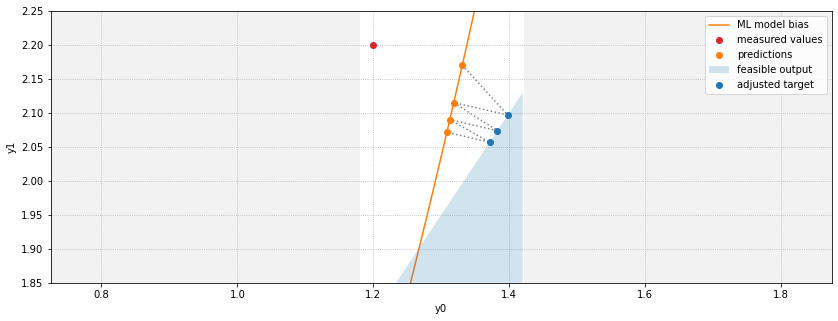

In [11]:
ypl, yfl, _ = util.mtx_moving_target_alpha(xm, ym, n=3, alpha=0.5)
util.mtx_output_plot(xm, ym, ypl, plot_bias=True, f_bound=f_bound, yf=yfl, figsize=figsize, ylim=(1.85, 2.25))

* Basically, MT zig-zags between the $B$ and the $C$ set
* This is not ideal, but it's the price we pay to enjoy a full decomposition

## The Final Outcome

**We can now inspect which kind of model we can obtain after some iterations**

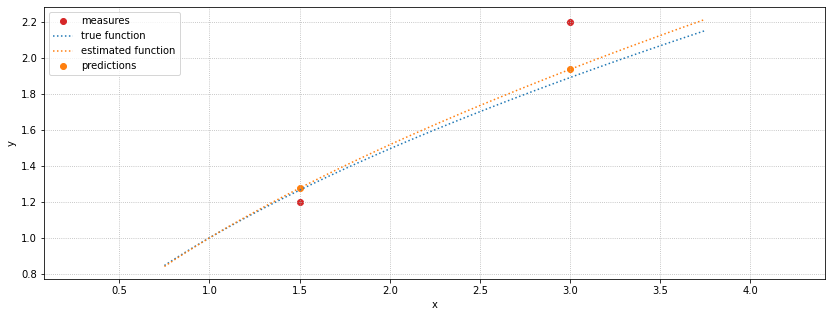

In [12]:
_, _, f_pred_final = util.mtx_moving_target_alpha(xm, ym, n=30, alpha=0.5)
util.mtx_function_plot(xm, ym, f_true, f_pred_final, figsize=figsize)

* This is very close to the true function!